In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf
from rdkit import Chem
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split

# matplotlib.rcParams.update({'font.size': 24})
# plt.style.use("ggplot")
PATH_DATA = "../datasets/CYP/"

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def clean_features(df):
    df = df.apply(pd.to_numeric, errors="coerce")
    # set all types to float64 otherwise zscore crashes
    df = df.astype("float64")
    # we treat values larger than 1e3 as nans
    df[df > 1e3] = None
    # drop all features that have some nan
    df = df.dropna(axis=1)
    # remove columns that contain values more than 2 standard deviations from the mean
    mask = ~np.any(np.abs(stats.zscore(df)) < 2, axis=0)
    df = df.drop(columns=df.columns[mask])
    return df

def get_features(input_sdf):
    calc = Calculator(descriptors, ignore_3D=True)
    features = calc.pandas(Chem.SDMolSupplier(input_sdf))
    return pd.DataFrame(features)

def common_columns(features_all, features_2c9, features_3a4):
    common = set(features_all.columns.values)
    common &= set(features_2c9.columns.values)
    common &= set(features_3a4.columns.values)
    return features_all[common], features_2c9[common], features_3a4[common]

def scale_df(df):
    # df[df.columns] = preprocessing.robust_scale(df[df.columns])
    df[df.columns] = preprocessing.scale(df[df.columns])
    return df

def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    
def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    
def draw_roc_curve(y_score, y_true, figsize=(6,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
if os.path.exists(os.path.join("features", "shared_set_features_mordred.csv")):
    features_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.csv"))
else:
    if os.path.exists(os.path.join("features", "shared_set_original_features_mordred.csv")):
        features_shared = pd.read_csv(os.path.join("features", "shared_set_original_features_mordred.csv"))
    else:
        features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
        features_shared.to_csv(os.path.join("features", "shared_set_original_features_mordred.csv"), index=False)
    features_shared = clean_features(features_shared)
    features_shared.to_csv(os.path.join("features", "shared_set_features_mordred.csv"), index=False)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features_mordred.csv")):
    features_only_2c9 = pd.read_csv(os.path.join("features", "only_2c9_set_features_mordred.csv"))
else:  
    if os.path.exists(os.path.join("features", "only_2c9_set_original_features_mordred.csv")):
        features_only_2c9 = pd.read_csv(os.path.join("features", "only_2c9_set_original_features_mordred.csv"))
    else:
        features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
        features_only_2c9.to_csv(os.path.join("features", "only_2c9_set_original_features_mordred.csv"), index=False)
    features_only_2c9 = clean_features(features_only_2c9)
    features_only_2c9.to_csv(os.path.join("features", "only_2c9_set_features_mordred.csv"), index=False)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features_mordred.csv")):
    features_only_3a4 = pd.read_csv(os.path.join("features", "only_3a4_set_features_mordred.csv"))
else:
    if os.path.exists(os.path.join("features", "only_3a4_set_original_features_mordred.csv")):
        features_only_3a4 = pd.read_csv(os.path.join("features", "only_3a4_set_original_features_mordred.csv"))
    else:
        features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
        features_only_3a4.to_csv(os.path.join("features", "only_3a4_set_original_features_mordred.csv"), index=False)
    features_only_3a4 = clean_features(features_only_3a4)
    features_only_3a4.to_csv(os.path.join("features", "only_3a4_set_features_mordred.csv"), index=False)

In [5]:
features_shared = scale_df(features_shared)
features_only_2c9 = scale_df(features_only_2c9)
features_only_3a4 = scale_df(features_only_3a4)

In [6]:
features_shared, features_only_2c9, features_only_3a4 = common_columns(features_shared, features_only_2c9, features_only_3a4)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [8]:
hidden_layers = 4
neurons = 50
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.summary()
history = model.fit(train_data, train_labels, epochs=10, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 568)               323192    
_________________________________________________________________
dropout (Dropout)            (None, 568)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                28450     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5

74/74 [==============================] - 0s 3ms/step - loss: 0.4552 - binary_accuracy: 0.8365
NER: 0.812, Sensitivity or recall: 0.745, Specificity: 0.880, Precision: 0.746, Correctly calssified: 0.837, MCC: 0.625


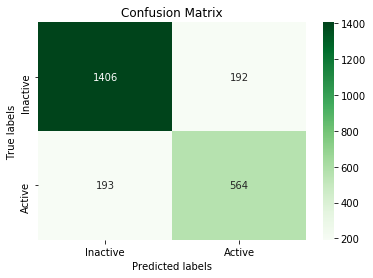

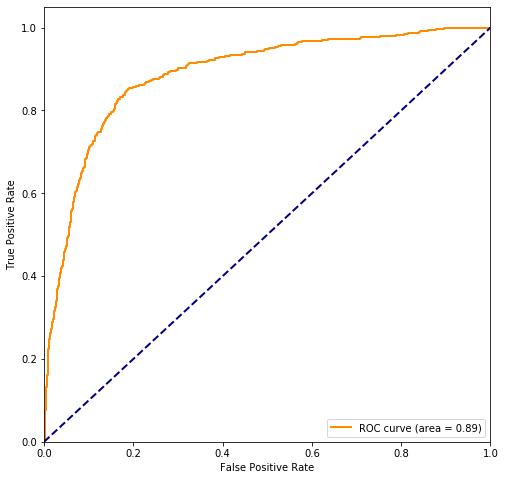

In [9]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
print_metrics(predictions, test_labels);
plot_confusion(predictions, test_labels);
draw_roc_curve(predictions, test_labels, figsize=(8,8))

88/88 [==============================] - 0s 3ms/step - loss: 0.6159 - binary_accuracy: 0.7572
NER: 0.713, Sensitivity or recall: 0.553, Specificity: 0.873, Precision: 0.710, Correctly calssified: 0.757, MCC: 0.455


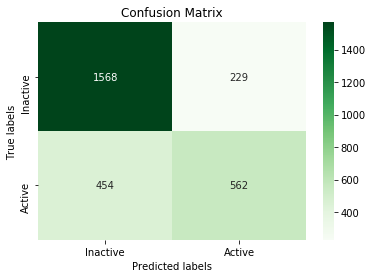

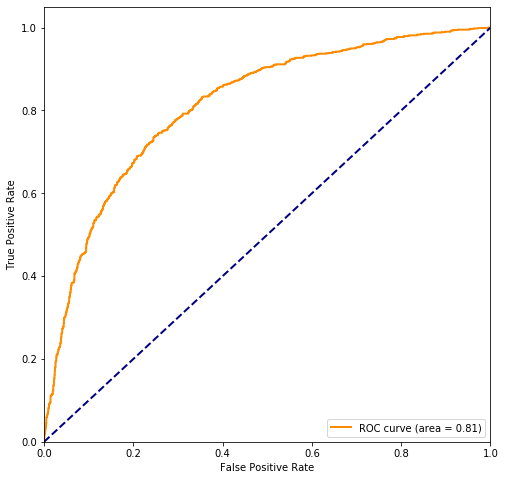

In [10]:
results = model.evaluate(features_only_2c9, labels_validation_2c9)
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_validation_2c9);
plot_confusion(predictions, labels_validation_2c9);
draw_roc_curve(predictions, labels_validation_2c9, figsize=(8,8))

[154.23287724  41.48752965  31.91171668  16.91293231  15.33990495
  14.5763386   12.03535854  10.70751043  10.44763329   9.04275033
   8.40622994   7.95667947   7.30114333   7.06389979   6.56442928
   6.36206723   6.1671739    5.78631397   5.57568102   5.09137505
   4.95002709   4.75487734   4.50094396   4.27108844   4.07248465
   4.03391065   3.96369131   3.80188321   3.77112045   3.58576268
   3.42761705   3.27615282   3.20384904   3.16820397   3.13861568
   2.93323146   2.85192757   2.78914858   2.77294305   2.65798055
   2.57340729   2.52091203   2.50064237   2.45409234   2.43275511
   2.39800593   2.31626394   2.24436249   2.2241625    2.20342184
   2.15339012   2.12137472   2.10579849   2.05318422   2.02557466
   1.96843683   1.93919201   1.91074548   1.87049722   1.84342006
   1.82286315   1.76454853   1.71750324   1.65829939   1.62800346
   1.5824222    1.52619071   1.51759237   1.46971421   1.4565761
   1.42858893   1.3883568    1.36764214   1.29755154   1.26488428
   1.247021

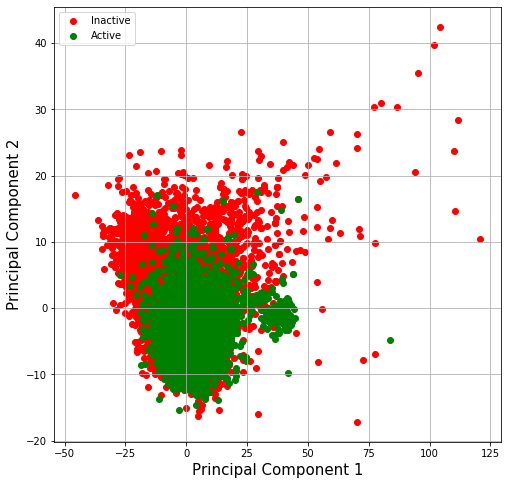

In [11]:
active_filter = labels_2c9 == 1
inactive_filter = labels_2c9 == 0
pca = PCA(0.95)
principalComponents = pca.fit_transform(features_shared)
print(pca.explained_variance_)
pca_features_2c9 = pca.transform(features_only_2c9)
pca_features_3a4 = pca.transform(features_only_3a4)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(principalComponents[inactive_filter,0], principalComponents[inactive_filter,1],c="red")
ax.scatter(principalComponents[active_filter,0], principalComponents[active_filter,1],c="green")
ax.legend(["Inactive", "Active"])
ax.grid()
plt.show()

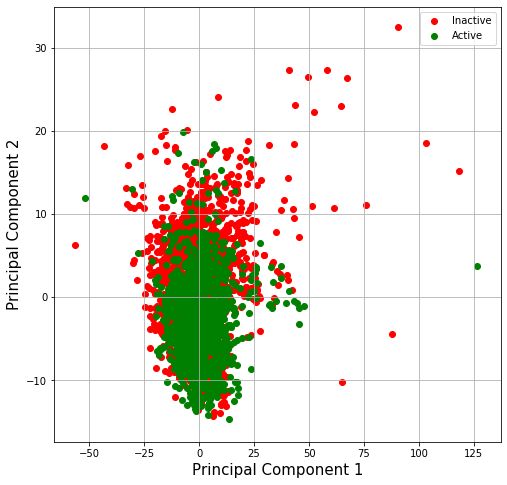

In [12]:
active_filter = labels_validation_2c9 == 1
inactive_filter = labels_validation_2c9 == 0
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(pca_features_2c9[inactive_filter,0], pca_features_2c9[inactive_filter,1],c="red")
ax.scatter(pca_features_2c9[active_filter,0], pca_features_2c9[active_filter,1],c="green")
ax.legend(["Inactive", "Active"])
ax.grid()
plt.show()

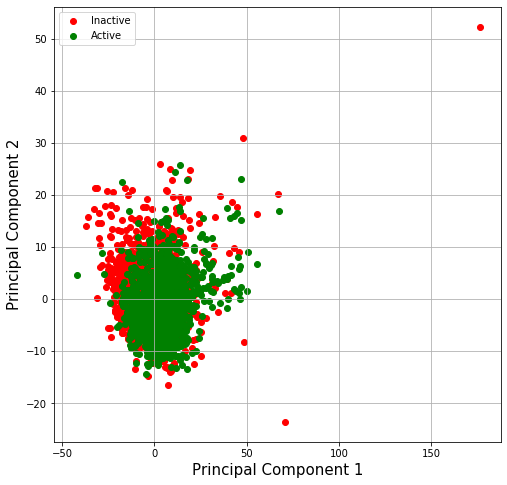

In [13]:
active_filter = labels_validation_3a4 == 1
inactive_filter = labels_validation_3a4 == 0
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(pca_features_3a4[inactive_filter,0], pca_features_3a4[inactive_filter,1],c="red")
ax.scatter(pca_features_3a4[active_filter,0], pca_features_3a4[active_filter,1],c="green")
ax.legend(["Inactive", "Active"])
ax.grid()
plt.show()

In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(principalComponents, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [15]:
print(N_BITS)
neurons = 8
hidden_layers = 6
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.summary()
history = model.fit(train_data, train_labels, epochs=10, verbose=2)

94
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 94)                8930      
_________________________________________________________________
dropout_1 (Dropout)          (None, 94)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 760       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 8)             

74/74 [==============================] - 0s 3ms/step - loss: 0.4188 - binary_accuracy: 0.8276
NER: 0.803, Sensitivity or recall: 0.734, Specificity: 0.872, Precision: 0.731, Correctly calssified: 0.828, MCC: 0.605


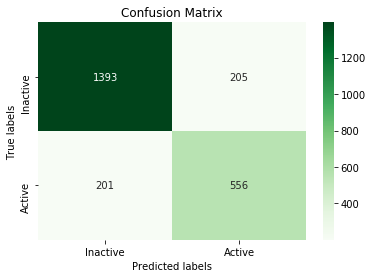

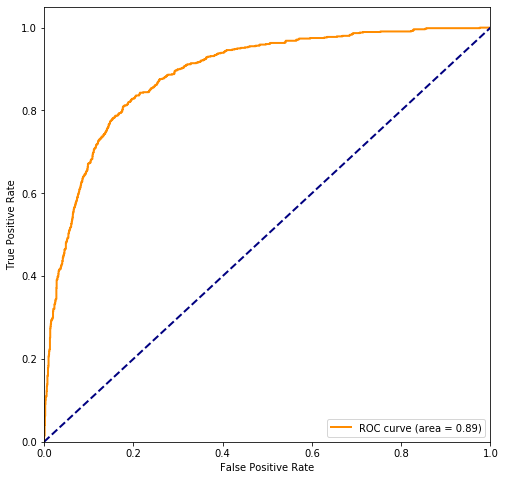

In [16]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
print_metrics(predictions, test_labels);
plot_confusion(predictions, test_labels);
draw_roc_curve(predictions, test_labels, figsize=(8,8))

88/88 [==============================] - 0s 3ms/step - loss: 0.6095 - binary_accuracy: 0.7497
NER: 0.702, Sensitivity or recall: 0.531, Specificity: 0.873, Precision: 0.703, Correctly calssified: 0.750, MCC: 0.436


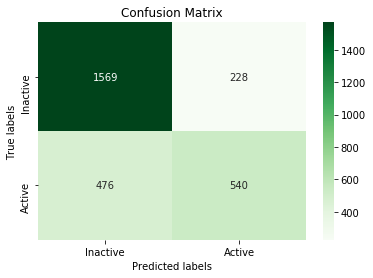

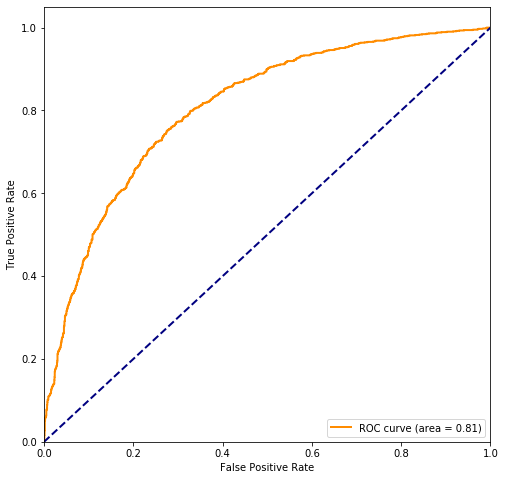

In [17]:
results = model.evaluate(pca_features_2c9, labels_validation_2c9)
predictions = model.predict(pca_features_2c9)
print_metrics(predictions, labels_validation_2c9);
plot_confusion(predictions, labels_validation_2c9);
draw_roc_curve(predictions, labels_validation_2c9, figsize=(8,8))

In [ ]:
kernels = ["rbf", "poly", "linear", "sigmoid"]
for k in kernels:
    svm = SVC(kernel=k, C=23)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(test_data)
    print(f"Scores using {k} kernel")
    print_metrics(predicted, test_labels)
    predictions = svm.predict(pca_features_2c9)
    print_metrics(predictions, labels_validation_2c9)

Scores using rbf kernel
NER: 0.802, Sensitivity or recall: 0.720, Specificity: 0.884, Precision: 0.746, Correctly calssified: 0.831, MCC: 0.609
NER: 0.704, Sensitivity or recall: 0.533, Specificity: 0.875, Precision: 0.708, Correctly calssified: 0.752, MCC: 0.441
Scores using poly kernel
NER: 0.760, Sensitivity or recall: 0.645, Specificity: 0.875, Precision: 0.710, Correctly calssified: 0.801, MCC: 0.534
NER: 0.698, Sensitivity or recall: 0.521, Specificity: 0.875, Precision: 0.702, Correctly calssified: 0.747, MCC: 0.429


In [19]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(test_data)
    print(f"Scores using C={c}")
    print_metrics(predicted, test_labels)

Scores using C=49.99999999999999
NER: 0.799, Sensitivity or recall: 0.720, Specificity: 0.878, Precision: 0.736, Correctly calssified: 0.827, MCC: 0.602
Scores using C=58.53899568613895
NER: 0.793, Sensitivity or recall: 0.712, Specificity: 0.875, Precision: 0.729, Correctly calssified: 0.823, MCC: 0.591
Scores using C=68.53628031883592
NER: 0.794, Sensitivity or recall: 0.715, Specificity: 0.872, Precision: 0.726, Correctly calssified: 0.822, MCC: 0.590
Scores using C=80.24090035856693
NER: 0.793, Sensitivity or recall: 0.717, Specificity: 0.869, Precision: 0.722, Correctly calssified: 0.820, MCC: 0.588
Scores using C=93.94443439884111
NER: 0.795, Sensitivity or recall: 0.723, Specificity: 0.868, Precision: 0.722, Correctly calssified: 0.821, MCC: 0.590
Scores using C=109.98825680021051
NER: 0.798, Sensitivity or recall: 0.728, Specificity: 0.867, Precision: 0.722, Correctly calssified: 0.823, MCC: 0.594
Scores using C=128.77204180706934
NER: 0.797, Sensitivity or recall: 0.729, Speci